In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from scipy import stats as st


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [2]:
metadata_all_raw = pd.read_csv("/content/drive/My Drive/LungAtlas/krasnow_hlca_10x_metadata_upload.csv")

In [3]:
metadata_epi_str_idx = [i for i, x in enumerate(metadata_all_raw["compartment"]) if (x in ["Epithelial", "Stromal"])]
metadata_epi_str = metadata_all_raw.iloc[metadata_epi_str_idx, :]
metadata_epi_str = metadata_epi_str[metadata_epi_str["free_annotation"] != "Pericyte"]
metadata_epi_str = metadata_epi_str[metadata_epi_str["free_annotation"] != "Mesothelial"]
metadata_epi_str = metadata_epi_str.reset_index(drop=True)

metadata_epi_idx = [i for i, x in enumerate(metadata_epi_str["compartment"]) if (x == "Epithelial")]
metadata_str_idx = [i for i, x in enumerate(metadata_epi_str["compartment"]) if (x == "Stromal")]

In [4]:
data_epi_str_raw_gene = pd.read_csv("/content/drive/My Drive/LungAtlas/data_epi_str_raw_gene.csv", index_col="Unnamed: 0")

In [5]:
sc = StandardScaler()
data_epi_str_gene_std = pd.DataFrame(sc.fit_transform(data_epi_str_raw_gene), index=data_epi_str_raw_gene.index, columns=data_epi_str_raw_gene.columns)
data_epi_str_gene_std = data_epi_str_gene_std.round(3)

In [6]:
tsne = TSNE(n_components=2, random_state=0)
feature = tsne.fit_transform(data_epi_str_gene_std.T)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

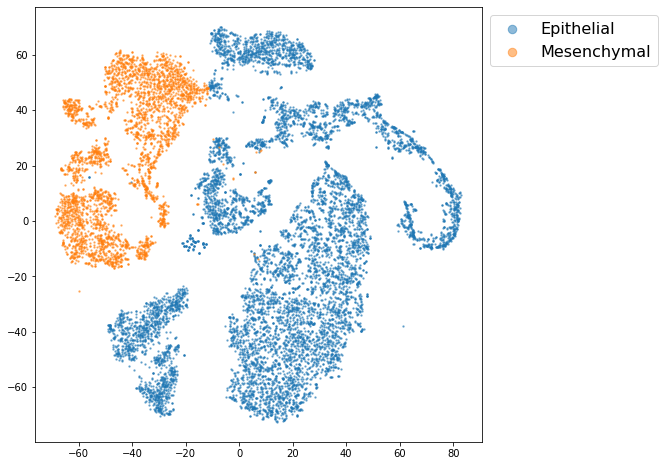

In [7]:
from google.colab import files

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(feature[metadata_epi_idx, 0], feature[metadata_epi_idx, 1], alpha=0.5, label="Epithelial", s=2)
ax.scatter(feature[metadata_str_idx, 0], feature[metadata_str_idx, 1], alpha=0.5, label="Stromal", s=2)

handles, labels = ax.get_legend_handles_labels()
labels = ["Epithelial", "Mesenchymal"]
ax.legend(labels, loc='upper left', bbox_to_anchor=(1, 1), markerscale=6, fontsize=16)

plt.savefig("EvsM.jpg", format="jpg", bbox_inches="tight")
files.download("EvsM.jpg")
plt.show()

In [ ]:
print(len(metadata_epi_idx))
print(len(metadata_str_idx))
data_epi_str_raw_gene.shape

9407
3396


(24569, 12803)

In [ ]:
data_epi_gene_std = data_epi_str_gene_std.iloc[:, metadata_epi_idx]
tsne2 = TSNE(n_components=2, random_state=0)
feature2 = tsne2.fit_transform(data_epi_gene_std.T)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

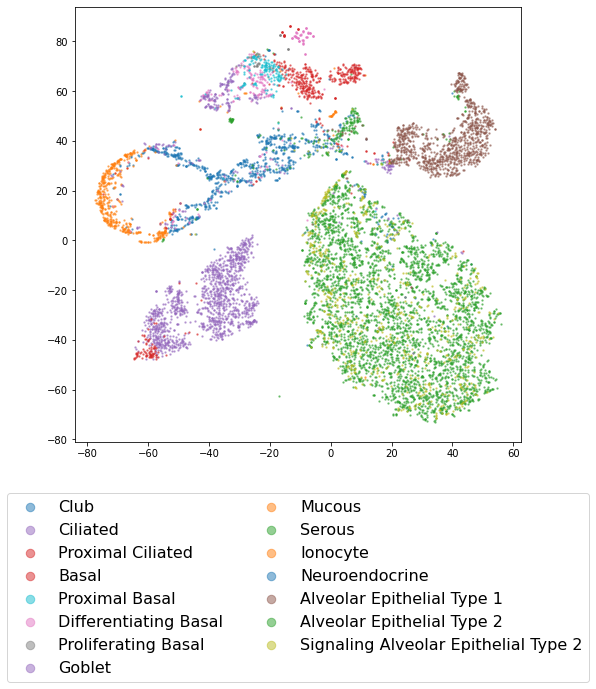

In [ ]:
metadata_epi = metadata_epi_str.iloc[metadata_epi_idx, :]
#metadata_epi = metadata_epi.reset_index(drop=True)
annotation_list = metadata_epi["free_annotation"].unique()

fig, ax = plt.subplots(figsize=(8, 8))
for annotation in annotation_list:
  feature2_sub = feature2[metadata_epi["free_annotation"] == annotation]
  ax.scatter(feature2_sub[:, 0], feature2_sub[:, 1], alpha=0.5, label=annotation, s=2)


handles, labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[4], handles[13], handles[3], handles[9], handles[6], handles[7], handles[14], handles[1], handles[12], handles[11], handles[10], handles[5], handles[2], handles[8]]
labels = [labels[0], labels[4], labels[13], labels[3], labels[9], labels[6], labels[7], labels[14], labels[1], labels[12], labels[11], labels[10], labels[5], labels[2], labels[8]]

ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, markerscale=6, fontsize=16)

plt.savefig("E_cluster.jpg", format="jpg", bbox_inches="tight")
files.download("E_cluster.jpg")
plt.show()

In [ ]:
data_str_gene_std = data_epi_str_gene_std.iloc[:, metadata_str_idx]
tsne3 = TSNE(n_components=2, random_state=0)
feature3 = tsne3.fit_transform(data_str_gene_std.T)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

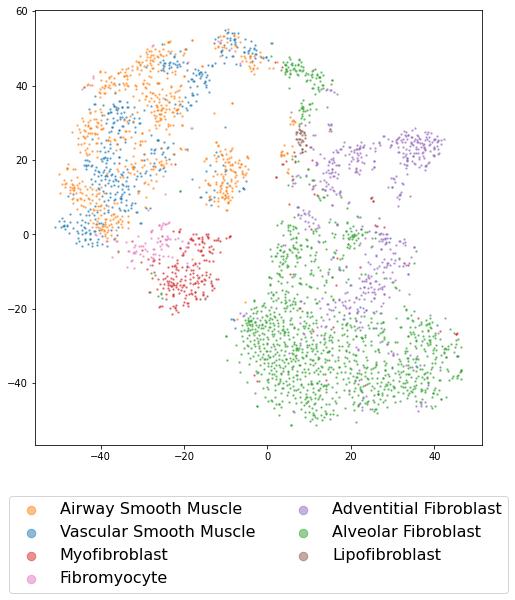

In [ ]:
metadata_str = metadata_epi_str.iloc[metadata_str_idx, :]
annotation_list = metadata_str["free_annotation"].unique()

fig, ax = plt.subplots(figsize=(8, 8))
for annotation in annotation_list:
  feature3_sub = feature3[metadata_str["free_annotation"] == annotation]
  ax.scatter(feature3_sub[:, 0], feature3_sub[:, 1], alpha=0.5, label=annotation, s=2)


handles, labels = ax.get_legend_handles_labels()

handles = [handles[1], handles[0], handles[3], handles[6], handles[4], handles[2], handles[5]]
labels = [labels[1], labels[0], labels[3], labels[6], labels[4], labels[2], labels[5]]

ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, markerscale=6, fontsize=16)

plt.savefig("M_cluster.jpg", format="jpg", bbox_inches="tight")
files.download("M_cluster.jpg")
plt.show()

In [ ]:
def ttest_row(x):
  _, pvalue = st.ttest_ind(x[metadata_epi_idx], x[metadata_str_idx])
  return pvalue

pvalues = data_epi_str_gene_std.apply(ttest_row, axis=1)
pvalues = pvalues.values


In [ ]:
gene128 = np.argsort(pvalues)[:128]
tcga_std_gene = pd.read_csv("/content/drive/My Drive/TCGA/tcga_std_gene.csv", index_col="Unnamed: 0")
tcga_std_gene_128 = tcga_std_gene.iloc[gene128,]

In [ ]:
clinical = pd.DataFrame(columns=["case_id", "event", "days"])

for i in range(len(tcga_std_gene.columns)):
  id = tcga_std_gene.columns[i]

  with open("/content/drive/My Drive/TCGA/clinical.tsv") as f:
    for s_line in f:
      sample = s_line.split("\t")
      if sample[0] == id:
        project = sample[2]
        age = sample[3]
        gender = sample[11]
        stage = sample[26]
        if sample[15] == "Dead":
          event = 1
        elif sample[15] == "Alive":
          event = 0
        days = sample[47]
        break

  clinical.loc[i] = [id, event, days]      

clinical = clinical.set_index("case_id")


In [ ]:
gene128_clinical = pd.concat([clinical, tcga_std_gene_128.T], axis=1)

In [ ]:
pip install lifelines

     |████████████████████████████████| 348kB 4.4MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=82be7e521a5ff39641935ff0459f50561d6a66f20f067ee1afbae96c2e1a5a89
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [ ]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [ ]:
gene128_clinical_2 = gene128_clinical[gene128_clinical["days"] != "'--"]
gene128_clinical_2 = gene128_clinical_2.astype(int)
gene128_clinical_3 = gene128_clinical_2.drop(['EFEMP2', 'GYPC', 'FBLN5', 'MACF1', 'EPB41L2', 'CTGF', 'PDLIM3', 'MALL', 'LAMA4', 'TCF4', 'ANGPT1', 'PPAP2A', 'ITGA1', 'PELO', 'SEPP1', 'CCDC102B', 'ARID5A', 'TGFB1I1', 'MT1M', 'TMEM47', 'HSPB2', 'EDNRA', 'SCN7A', 'TCF21', 'PLAC9', 'LMOD1', 'ZAK', 'GUCY1A3', 'PPP1R12B', 'FHL1', 'PRKCDBP', 'ILK', 'ANGPTL1', 'CNN1', 'PTGIR', 'FGFR4', 'FXYD1', 'TSPAN4', 'RGS3', 'CPQ', "AKAP12", "CCDC85B", "CSRP1", "CTSF", "DPT", "F2R", "HSPB6", "LOXL1", "MRGPRF", "NDN", "NKD2", "PDLIM7", "PPP1R14A"], axis=1)

cph = CoxPHFitter()
cph.fit(gene128_clinical_3, duration_col="days", event_col="event")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 790 total observations, 617 right-censored observations>
             duration col = 'days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 790
number of events observed = 173
   partial log-likelihood = -1016.20
         time fit was run = 2021-01-05 04:11:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
SDC2        0.31       1.36       0.47            -0.62             1.23                 0.54                 3.43
MALAT1     -0.01       0.99       0.02            -0.06             0.03                 0.94                 1.04
ACTA2       0.34       1.41       0.20            -0.05             0.74                 0.95                 2.09
MUC1        0.08       1.09       0.07            -0.06             0.22                 0.95                 1.25
TIMP1      -0.00       1.00       0.02            -0.04             0.03                 0.96                 1.03
FOS         0.20       1.22       0.12            -0.03             0.42                 0.97                 1.53
TUBB6      -0.74       0.48       0.57            -1.86             0.39                 0.16                 1.47
EPCAM      -0.02       0.98       0.07            -0.16             0.11                 0.85                 1.12
RTN4        0.27       1.31       0.34            -0.40             0.94                 0.67                 2.57
VAMP8      -0.02       0.98       0.10            -0.21             0.17                 0.81                 1.18
SFTPB       0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
CYB5A       0.91       2.48       1.21            -1.46             3.27                 0.23                26.42
C7         -0.01       0.99       0.64            -1.26             1.24                 0.28                 3.45
MAL2        0.09       1.09       0.09            -0.09             0.27                 0.91                 1.32
LMNA        0.04       1.04       0.18            -0.31             0.39                 0.73                 1.47
PNRC1      -0.07       0.93       0.80            -1.64             1.49                 0.19                 4.44
NPC2       -0.06       0.94       0.07            -0.20             0.07                 0.82                 1.08
FRZB        0.95       2.59       0.94            -0.88             2.79                 0.41                16.23
TFPI        0.44       1.55       0.66            -0.85             1.72                 0.43                 5.59
SPRY1     -12.27       0.00    2351.57         -4621.27          4596.73                 0.00                  inf
TIMP2      -0.32       0.73       0.25            -0.81             0.18                 0.45                 1.19
FLNA       -0.03       0.97       0.11            -0.24             0.18                 0.79                 1.19
NPNT        0.56       1.75       0.63            -0.68             1.79                 0.51                 6.00
ADH1B       1.52       4.59       1.47            -1.35             4.40                 0.26                81.69
PSAP       -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
SPARCL1     0.23       1.26       0.09             0.05             0.41                 1.05                 1.51
CRYAB      -0.02       0.98       0.33            -0.66             0.63                 0.52                 1.87
BTG2        0.01       1.01       0.21            -0.39             0.42                 0.68                 1.52
LTBP2      -1.31       0.27       0.75            -2.79             0.16                 0.06                 1.18
BGN        -0.00       1.00       0.05            -0.10             0.09     

In [ ]:
cph.summary.index

Index(['SDC2', 'MALAT1', 'ACTA2', 'MUC1', 'TIMP1', 'FOS', 'TUBB6', 'EPCAM',
       'RTN4', 'VAMP8', 'SFTPB', 'CYB5A', 'C7', 'MAL2', 'LMNA', 'PNRC1',
       'NPC2', 'FRZB', 'TFPI', 'SPRY1', 'TIMP2', 'FLNA', 'NPNT', 'ADH1B',
       'PSAP', 'SPARCL1', 'CRYAB', 'BTG2', 'LTBP2', 'BGN', 'MMP2', 'PALLD',
       'CPE', 'SFTPD', 'SFTPA1', 'SFTPA2', 'ELF3', 'ACTN1', 'FN1', 'FSTL3',
       'AXL', 'CXCL17', 'JUNB', 'CLIC4', 'CTSH', 'DKK3', 'QSOX1', 'SDR16C5',
       'LTBP4', 'ZFP36', 'IFITM3', 'FXYD3', 'CAMK2N1', 'PLS3', 'SFTA2', 'TUBB',
       'TACC1', 'FGFR1', 'COX7A1', 'TSC22D3', 'MFGE8', 'TPM4', 'ZFP36L2',
       'DUSP1', 'EMP3', 'DST', 'EGR1', 'THBS1', 'TINAGL1', 'LAPTM4A', 'GEM',
       'SERPING1', 'MYH11', 'EMILIN1', 'LBH'],
      dtype='object', name='covariate')

In [ ]:
d = "\n".join(cph.summary.index)
with open('gene_list.txt', 'w') as f:
  f.write(d)


In [ ]:
from google.colab import files
files.download("gene_list.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
SDC2,0.306017,1.358005,0.472011,-0.619109,1.231142,0.538424,3.425138,0.648324,0.516775,0.952391
MALAT1,-0.014105,0.985994,0.024824,-0.062758,0.034548,0.939170,1.035152,-0.568211,0.569892,0.811240
ACTA2,0.343153,1.409384,0.201766,-0.052301,0.738607,0.949043,2.093018,1.700746,0.088991,3.490200
MUC1,0.082739,1.086259,0.070562,-0.055559,0.221037,0.945957,1.247370,1.172586,0.240962,2.053123
TIMP1,-0.004175,0.995834,0.019422,-0.042242,0.033891,0.958638,1.034472,-0.214965,0.829795,0.269173
...,...,...,...,...,...,...,...,...,...,...
GEM,-0.749722,0.472498,0.755512,-2.230497,0.731054,0.107475,2.077269,-0.992336,0.321034,1.639204
SERPING1,0.119440,1.126866,0.162130,-0.198329,0.437209,0.820100,1.548380,0.736694,0.461309,1.116196
MYH11,-1.377590,0.252186,1.072295,-3.479250,0.724069,0.030831,2.062810,-1.284712,0.198893,2.329936


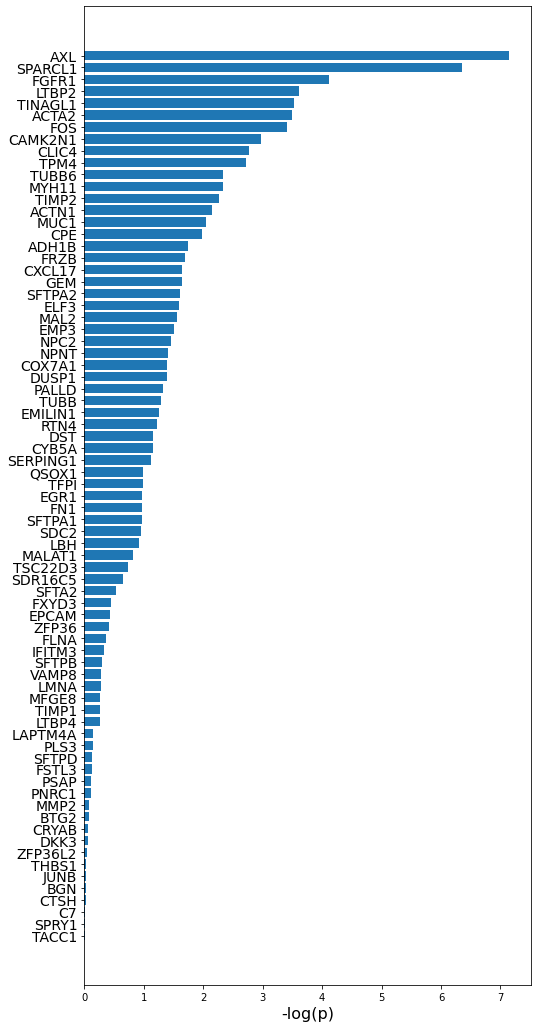

In [ ]:
result_summary_sort = cph.summary.sort_values("-log2(p)", ascending=False)

fig, ax = plt.subplots(figsize=(8, 18))

ax.barh(result_summary_sort.index, result_summary_sort["-log2(p)"])

#xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel = "-log(p)"

#ax.set_xticklabels(xticklabels,fontsize=12)
ax.set_yticklabels(result_summary_sort.index,fontsize=14)
ax.set_xlabel(xlabel,fontsize=16)

ax.invert_yaxis()

plt.savefig("survival_gene.jpg", format="jpg", bbox_inches="tight")
files.download("survival_gene.jpg")
plt.show()

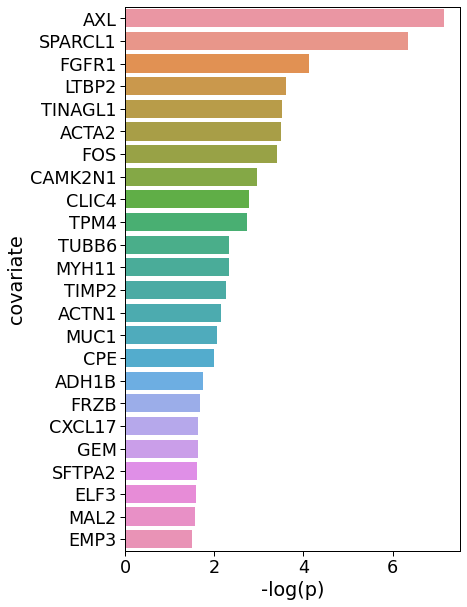

In [ ]:
import matplotlib.ticker as ticker

result_summary_sort_select = result_summary_sort[result_summary_sort['-log2(p)'] >1.5 ]

fig, ax = plt.subplots(figsize=(6, 10))

sns.barplot(x="-log2(p)", y=result_summary_sort_select.index, data=result_summary_sort_select, orient="h", ax=ax)
sns.set_context(context="paper")
ax.set_xlabel('-log(p)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2)) 